In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

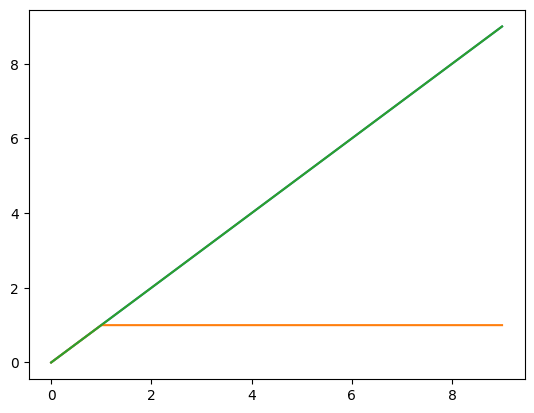

In [7]:
# data是非平稳序列
data = pd.DataFrame(np.array(range(10)), columns=["capaciy"])
head = data.iloc[0].item()
# 一阶差分后data_diff为平稳序列
data_diff = data.diff().fillna(head)
# 一阶差分后复原
data_recovery = data_diff.cumsum().fillna(head)

# plt.plot(data)
# plt.plot(data_diff)
# plt.plot(data_recovery)

In [84]:
calce_data_path = "./data/calce/CALCE.npy"
calce_data = np.load(calce_data_path, allow_pickle=True).item()
names = list(calce_data.keys())
b35 = calce_data[names[0]]["capacity"]
b36 = calce_data[names[1]]["capacity"]
b37 = calce_data[names[2]]["capacity"]
b38 = calce_data[names[3]]["capacity"]

print(b35)

0      1.126385
1      1.126160
2      1.125966
3      1.118508
4      1.117210
         ...   
877    0.339218
878    0.330025
879    0.330027
880    0.320860
881    0.320863
Name: capacity, Length: 882, dtype: float64


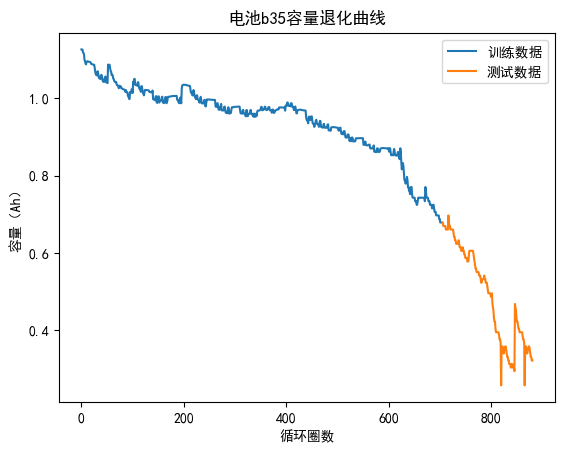

0      1.126385
1      1.126160
2      1.125966
3      1.118508
4      1.117210
         ...   
700    0.687570
701    0.678382
702    0.678403
703    0.678389
704    0.678386
Name: capacity, Length: 705, dtype: float64


In [44]:
dataset = b35
train_len = int(len(dataset) * 0.8)
train_dataset = dataset[0:train_len]
test_dataset = dataset[train_len:]
# print(len(train_dataset), len(test_dataset)) # 705, 177
train_dataset.plot()
test_dataset.plot()
plt.title("电池b35容量退化曲线")
plt.legend(["训练数据", "测试数据"])
plt.xlabel("循环圈数")
plt.ylabel("容量（Ah）")
plt.show()
print(train_dataset)

In [40]:
from statsmodels.tsa.stattools import adfuller # adf平稳性检验
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # 打印自相关图和偏自相关图
from statsmodels.stats.diagnostic import acorr_ljungbox # 白噪声检验

In [51]:
# 平稳性检验
print(adfuller(train_dataset)) # 对训练数据进行平稳性检验，非平稳
# 对训练集进行一阶差分，检查一阶差分后时间序列的平稳性
head = train_dataset.iloc[0].item()
train_dataset_diff = train_dataset.diff().dropna()
print(adfuller(train_dataset_diff)) # 平稳
# train_dataset_diff.plot()

# 白噪声检验
# 序列通过平稳性检验后进行白噪声检验，若序列为白噪声，则其取值完全随机，过去行为对未来没有任何影响，分析无意义
print(train_dataset_diff.shape) # 样本数大于500，使用Q统计量
acorr_ljungbox(train_dataset_diff, lags=[6, 12, 24], boxpierce=True) # 非白噪声

(1.3728913619564918, 0.9969874439236295, 10, 694, {'1%': -3.4398077121659765, '5%': -2.865713608066101, '10%': -2.5689925469026402}, -5035.620989609257)
(-7.826058756590433, 6.477195826695102e-12, 9, 694, {'1%': -3.4398077121659765, '5%': -2.865713608066101, '10%': -2.5689925469026402}, -5027.558526084523)
(704,)


,lb_stat,lb_pvalue,bp_stat,bp_pvalue
6,44.155465,6.885470e-08,43.882572,7.799206e-08
12,114.394117,8.059034e-19,113.076559,1.471287e-18
24,162.385978,1.600175e-22,159.676755,5.166692e-22


/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/tmp/ipykernel_101196/3270049329.py:5: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


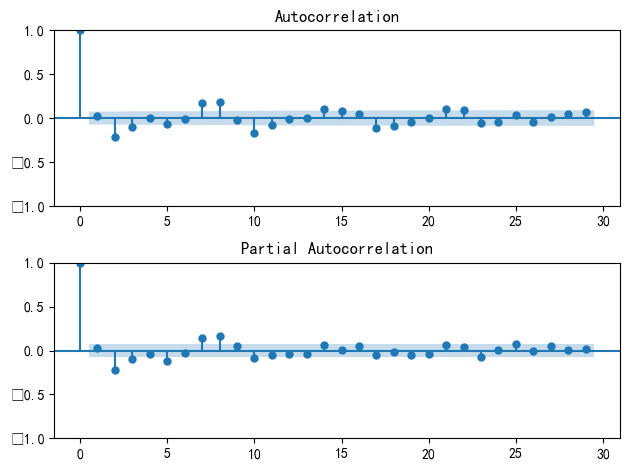

In [52]:
# 展示自相关图和偏相关图
fig, ax = plt.subplots(2, 1)
plot_acf(train_dataset_diff, ax[0])
plot_pacf(train_dataset_diff, ax[1])
plt.tight_layout()
plt.show()

In [55]:
from statsmodels.tsa.ar_model import AutoReg # auto regression模型
from sklearn.metrics import mean_squared_error as MSE # 评价指标

In [173]:
from utils import metrics

(617,) (616,)
maxE: 0.8466630546056607
mae: 0.01607913012378816
rmse:0.058912680024643116


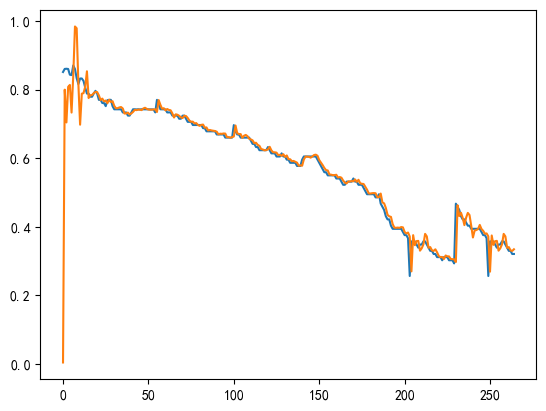

In [176]:
dataset = b35
train_len = int(len(dataset) * 0.7)
train_dataset = dataset[0:train_len].values
# train_dataset_diff = train_dataset.diff().dropna().values
test_dataset = dataset[train_len:].values
# test_dataset_diff = test_dataset.diff().dropna().values

print(train_dataset.shape, train_dataset_diff.shape)

# 建模
p = 16
model = AutoReg(train_dataset, lags=p)
model_fit = model.fit()
params = model_fit.params
# print(params)

# 预测
history = train_dataset_diff[-p:]
history = np.hstack(history).tolist()
pred = []
for t in range(len(test_dataset)):
    y_hat = params[0] # const
    for i in range(p):
        y_hat += params[i + 1] * history[-1 - i]
    pred.append(y_hat)
    history.append(test_dataset[t])

plt.plot(test_dataset)
plt.plot(pred)

maxE, mae, rmse = metrics.evaluation(test_dataset, pred)
print(f"maxE: {maxE}\nmae: {mae}\nrmse:{rmse}")

(655,) (616,)
maxE: 0.7590615722649802
mae: 0.021440401450572497
rmse:0.06974215094177379


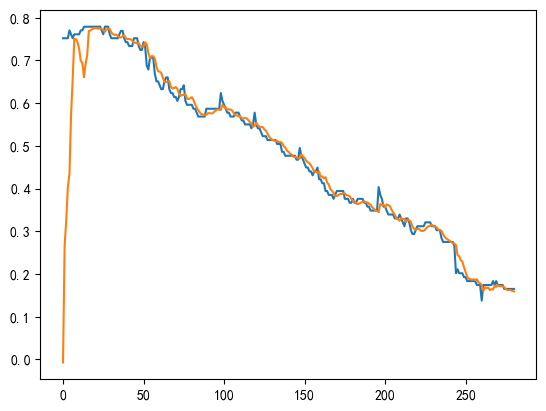

In [177]:
dataset = b36
train_len = int(len(dataset) * 0.7)
train_dataset = dataset[0:train_len].values
# train_dataset_diff = train_dataset.diff().dropna().values
test_dataset = dataset[train_len:].values
# test_dataset_diff = test_dataset.diff().dropna().values

print(train_dataset.shape, train_dataset_diff.shape)

# 建模
p = 16
model = AutoReg(train_dataset, lags=p)
model_fit = model.fit()
params = model_fit.params
# print(params)

# 预测
history = train_dataset_diff[-p:]
history = np.hstack(history).tolist()
pred = []
for t in range(len(test_dataset)):
    y_hat = params[0] # const
    for i in range(p):
        y_hat += params[i + 1] * history[-1 - i]
    pred.append(y_hat)
    history.append(test_dataset[t])

plt.plot(test_dataset)
plt.plot(pred)

maxE, mae, rmse = metrics.evaluation(test_dataset, pred)
print(f"maxE: {maxE}\nmae: {mae}\nrmse:{rmse}")

(680,) (616,)
maxE: 0.8090880323456129
mae: 0.020427421647807125
rmse:0.06932559037099537


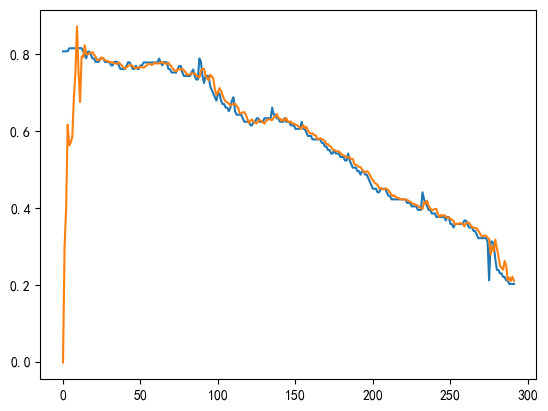

In [178]:
dataset = b37
train_len = int(len(dataset) * 0.7)
train_dataset = dataset[0:train_len].values
# train_dataset_diff = train_dataset.diff().dropna().values
test_dataset = dataset[train_len:].values
# test_dataset_diff = test_dataset.diff().dropna().values

print(train_dataset.shape, train_dataset_diff.shape)

# 建模
p = 16
model = AutoReg(train_dataset, lags=p)
model_fit = model.fit()
params = model_fit.params
# print(params)

# 预测
history = train_dataset_diff[-p:]
history = np.hstack(history).tolist()
pred = []
for t in range(len(test_dataset)):
    y_hat = params[0] # const
    for i in range(p):
        y_hat += params[i + 1] * history[-1 - i]
    pred.append(y_hat)
    history.append(test_dataset[t])

plt.plot(test_dataset)
plt.plot(pred)

maxE, mae, rmse = metrics.evaluation(test_dataset, pred)
print(f"maxE: {maxE}\nmae: {mae}\nrmse:{rmse}")

(697,) (616,)
maxE: 0.8307327143057719
mae: 0.020788624716239098
rmse:0.06803047506373866


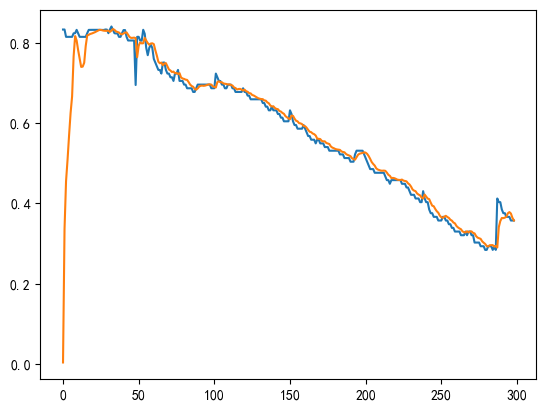

In [179]:
dataset = b38
train_len = int(len(dataset) * 0.7)
train_dataset = dataset[0:train_len].values
# train_dataset_diff = train_dataset.diff().dropna().values
test_dataset = dataset[train_len:].values
# test_dataset_diff = test_dataset.diff().dropna().values

print(train_dataset.shape, train_dataset_diff.shape)

# 建模
p = 16
model = AutoReg(train_dataset, lags=p)
model_fit = model.fit()
params = model_fit.params
# print(params)

# 预测
history = train_dataset_diff[-p:]
history = np.hstack(history).tolist()
pred = []
for t in range(len(test_dataset)):
    y_hat = params[0] # const
    for i in range(p):
        y_hat += params[i + 1] * history[-1 - i]
    pred.append(y_hat)
    history.append(test_dataset[t])

plt.plot(test_dataset)
plt.plot(pred)

maxE, mae, rmse = metrics.evaluation(test_dataset, pred)
print(f"maxE: {maxE}\nmae: {mae}\nrmse:{rmse}")